# Installation

In [1]:
import os
import pickle

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler # scalers
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')

In [2]:
os.makedirs("./checkpoint/", exist_ok=True)

## Configuration

In [3]:
files = {
    'daily': "INDEX_BTCUSD, 1D updated.csv", 
    '4hour': "INDEX_BTCUSD, 240 updated.csv", 
    '15min': "INDEX_BTCUSD, 15.csv"
}
config = {
    # architecture
    'cell_type': "LSTM",
    'hidden': 50,
    'nlayers': 5,

    # training
    'epochs': 50,
    'lr': 0.001,
    'drop': 0.2,
    'bs': 32,
    'seed': 2021,

    # data
    'train_file': files["15min"],
    'features': ["close"], # close, open, high, low, volume, ma, ema, rsi, premium, funding, hist
    'seqlen': 90, # timeframes
    'future': 1, # how many values to predict
    'split': 0.67,
}

In [4]:
if config['seed'] != None:
  np.random.seed(config['seed'])
  tf.random.set_seed(config['seed'])

# Setup

## Load data

In [5]:
# load and format
dataset = pd.read_csv(config['train_file'])
dataset['time'] = pd.to_datetime(dataset['time'])
dataset = dataset.rename(columns={'MA':'ma', 'EMA 200':'ema', 'RSI':'rsi', 'Premium Index':'premium', 'Funding Rate':'funding', 'Histogram':'hist'})
data = dataset[config['features']]

# scale
scaler = MinMaxScaler(feature_range=(-1, 1))
col_to_scale = data.columns.isin(['open', 'close', 'high', 'low'])
data.loc[:, col_to_scale] = scaler.fit_transform(data.loc[:, col_to_scale])

# split
N = data.shape[0]
train_data = data.iloc[:int(N*config['split'])].values
val_data = data.iloc[int(N*config['split']):].values

# preprocess data
def _preprocess(d):
  X, y = [], []
  for i in range(d.shape[0]-config['seqlen']-config['future']):
    X.append(d[i: i+config['seqlen']])
    y.append(d[i: i+config['future'], 0])
  return np.array(X), np.array(y)

X_train, y_train = _preprocess(train_data)
X_val, y_val = _preprocess(val_data)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [6]:
# verify shapes
print(X_train.shape)
print(y_train.shape)

(7877, 90, 1)
(7877, 1)


In [7]:
# all data
X, y = _preprocess(data.values)

## Create model

In [8]:
# get RNN cell
cell = getattr(tf.keras.layers, config['cell_type'])

# initialise layers
layers = [tf.keras.layers.InputLayer((config['seqlen'], len(config['features'])))]
for l in range(config['nlayers']):
  layers += [
      cell(units=config['hidden'], return_sequences=(l<config['nlayers']-1)),
      tf.keras.layers.Dropout(config['drop']),
  ]
layers += [tf.keras.layers.Dense(units=config['future'])]

# create model
regressor = tf.keras.Sequential(layers=layers, name="CryptoRegressor")

In [9]:
regressor.summary()

Model: "CryptoRegressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 90, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 90, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 90, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 90, 50)        

## Initialise optimizer


In [10]:
# define custom metrics
class UnscaledRMSE(tf.keras.metrics.Metric):
  def __init__(self, name='unscaled_rmse', **kwargs):
    super(UnscaledRMSE, self).__init__(name=name, **kwargs)
    self.unscaled_rmse = self.add_weight(name='urmse', initializer='zeros')
    self.m = tf.keras.metrics.RootMeanSquaredError()

  def update_state(self, y_true, y_pred, sample_weight=None):
    unscaled_ytrue = scaler.inverse_transform(y_true.numpy())
    unscaled_ypred = scaler.inverse_transform(y_pred.numpy())

    urmse = np.sqrt(mean_squared_error(unscaled_ytrue, unscaled_ypred))
    self.unscaled_rmse.assign(urmse)
    return self.unscaled_rmse

  def result(self):
    return self.unscaled_rmse

In [11]:
# compile model
regressor.compile(
    optimizer='adam', 
    loss='mean_squared_error', 
    metrics=['mae', UnscaledRMSE()], 
    run_eagerly=True # because of .numpy() in UnscaledRMSE
)

# Training

In [12]:
history = regressor.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=config['epochs'],
    batch_size=config['bs']
)

Epoch 1/50
247/247 [==============================] - 34s 124ms/step - loss: 0.0184 - mae: 0.1020 - unscaled_rmse: 2389.9229 - val_loss: 0.0080 - val_mae: 0.0693 - val_unscaled_rmse: 2201.6450
Epoch 2/50
247/247 [==============================] - 27s 109ms/step - loss: 0.0124 - mae: 0.0874 - unscaled_rmse: 1338.9426 - val_loss: 0.0162 - val_mae: 0.1015 - val_unscaled_rmse: 2445.3877
Epoch 3/50
247/247 [==============================] - 27s 108ms/step - loss: 0.0093 - mae: 0.0759 - unscaled_rmse: 1635.8687 - val_loss: 0.0083 - val_mae: 0.0637 - val_unscaled_rmse: 1235.4053
Epoch 4/50
247/247 [==============================] - 27s 109ms/step - loss: 0.0079 - mae: 0.0695 - unscaled_rmse: 1270.8684 - val_loss: 0.0051 - val_mae: 0.0498 - val_unscaled_rmse: 1141.4052
Epoch 5/50
247/247 [==============================] - 27s 110ms/step - loss: 0.0066 - mae: 0.0638 - unscaled_rmse: 1162.6171 - val_loss: 0.0036 - val_mae: 0.0502 - val_unscaled_rmse: 373.6783
Epoch 6/50
247/247 [================

In [13]:
# save history
with open("history.pickle", 'wb') as f:
  pickle.dump(history.history, f)

# save model
history.model.save_weights("./checkpoint/crypto_regressor_checkpoint", overwrite=True)

# Results

In [14]:
train_df = pd.DataFrame({
  'type':"train", 
  'loss':history.history['loss'], 
  'mae':history.history['mae'], 
  'unscaled_rmse':history.history['unscaled_rmse'], 
  'steps':range(len(history.history['loss']))
})
valid_df = pd.DataFrame({
  'type':"valid", 
  'loss':history.history['val_loss'], 
  'mae':history.history['val_mae'], 
  'unscaled_rmse':history.history['val_unscaled_rmse'], 
  'steps':range(len(history.history['val_loss']))
})  
history_df = pd.concat([train_df, valid_df])

## Loss

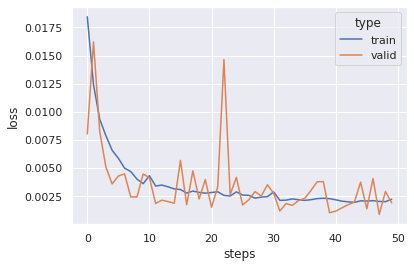

In [15]:
sns.lineplot(data=history_df, x='steps', y='loss', hue='type')

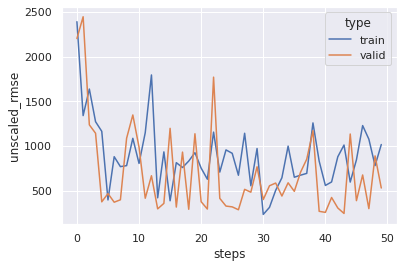

In [16]:
sns.lineplot(data=history_df, x='steps', y='unscaled_rmse', hue='type')

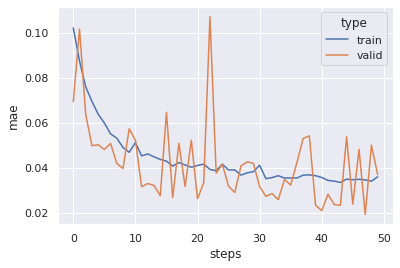

In [17]:
sns.lineplot(data=history_df, x='steps', y='mae', hue='type')

## Predictions

In [18]:
predictions = np.empty_like(dataset['time'])
predictions[config['seqlen']+config['future']:,] = scaler.inverse_transform(regressor.predict(X)).squeeze()

true_df = pd.DataFrame({
    'time': dataset['time'],
    'value': dataset['close'],
    'type': "real"
})
pred_df = pd.DataFrame({
    'time': dataset['time'],
    'value': predictions,
    'type': "predicted"
})

results_df = pd.concat([true_df, pred_df]).fillna(value=np.nan)

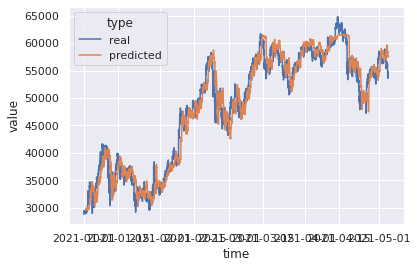

In [19]:
sns.lineplot(data=results_df, x='time', y='value', hue='type')

## Performance on all datasets

In [20]:
all_results = []
evaluation = {}

In [21]:
for dataset_name, file_name in files.items():
  print("{:*^30}".format(" "+dataset_name+" "))
  # load and format
  dataset = pd.read_csv(file_name)
  dataset['time'] = pd.to_datetime(dataset['time'])
  dataset = dataset.rename(columns={'MA':'ma', 'EMA 200':'ema', 'RSI':'rsi', 'Premium Index':'premium', 'Funding Rate':'funding', 'Histogram':'hist'})
  data = dataset[config['features']]

  # scale
  scaler = MinMaxScaler(feature_range=(-1, 1))
  col_to_scale = data.columns.isin(['open', 'close', 'high', 'low'])
  data.loc[:, col_to_scale] = scaler.fit_transform(data.loc[:, col_to_scale])

  # preprocess
  X, y = _preprocess(data.values)

  # predict
  predictions = np.empty_like(dataset['time'])
  predictions[config['seqlen']+config['future']:,] = scaler.inverse_transform(regressor.predict(X)).squeeze()

  # evaluate
  evaluation[dataset_name] = regressor.evaluate(X, y, return_dict=True)

  # collect results
  res = pd.concat([
      pd.DataFrame(dict(time=dataset['time'], value=dataset['close'], type="real")),
      pd.DataFrame(dict(time=dataset['time'], value=predictions, type="predicted")),
  ]).fillna(value=np.nan)
  res['dataset'] = dataset_name

  all_results.append(res)

all_results = pd.concat(all_results)
evaluation = pd.DataFrame(evaluation)

*********** daily ************


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


120/120 [==============================] - 7s 60ms/step - loss: 7.2693e-04 - mae: 0.0258 - unscaled_rmse: 1499.4382
*********** 4hour ************


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


363/363 [==============================] - 22s 60ms/step - loss: 6.3183e-04 - mae: 0.0226 - unscaled_rmse: 2916.7554
*********** 15min ************


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


369/369 [==============================] - 22s 60ms/step - loss: 0.0011 - mae: 0.0265 - unscaled_rmse: 528.4690


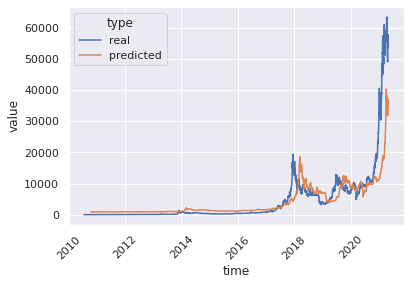

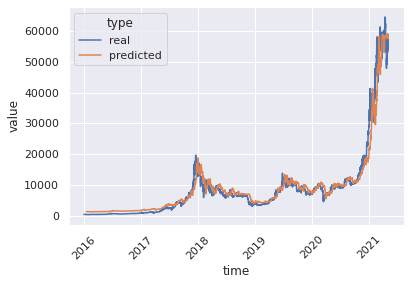

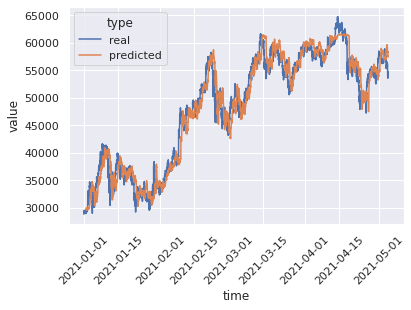

In [35]:
for dataset_name in files.keys():
  plt.figure()
  ax = sns.lineplot(data=all_results[all_results['dataset']==dataset_name], x='time', y='value', hue='type')
  for tick in ax.get_xticklabels():
    tick.set_rotation(45)
  ax.figure.savefig(f"best_predictions_{dataset_name}.png")

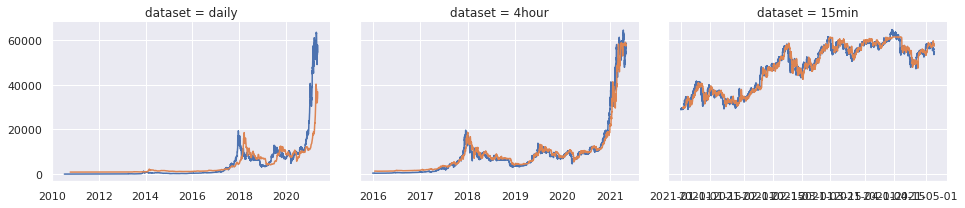

In [24]:
# plot prediction on whole dataset (foreach dataset)
g = sns.FacetGrid(data=all_results, col='dataset', sharex=False, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='value', hue='type')

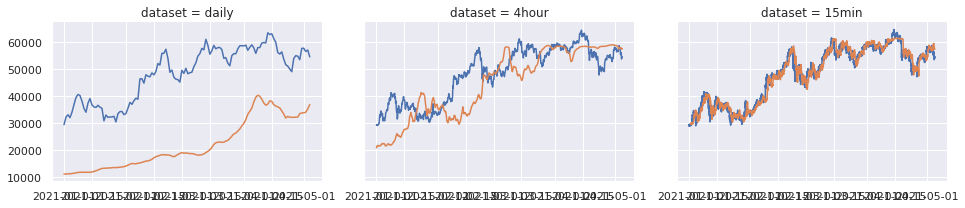

In [25]:
# plot prediction on the same portion of data
start_date = all_results.loc[all_results['dataset']=="15min", "time"].min()

g = sns.FacetGrid(data=all_results[all_results['time'] >= start_date], col='dataset', sharex=False, height=3, aspect=1.5)
g.map_dataframe(sns.lineplot, x='time', y='value', hue='type')

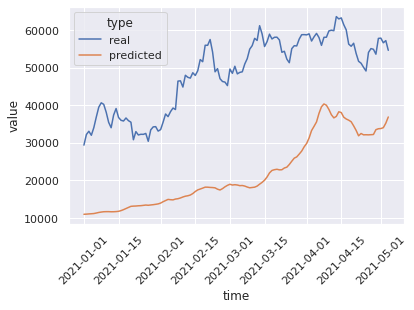

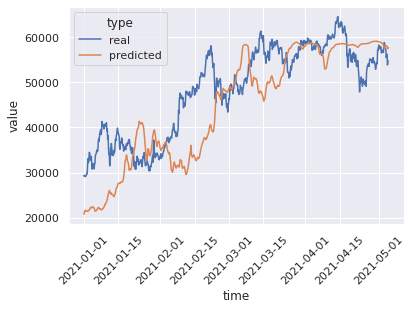

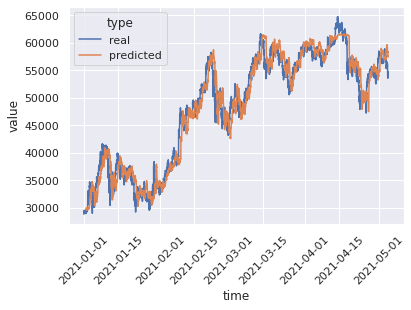

In [36]:
for dataset_name in files.keys():
  d = all_results[all_results['dataset'] == dataset_name]
  d = d[d['time'] >= start_date]
  plt.figure()
  ax = sns.lineplot(data=d, x='time', y='value', hue='type')
  for tick in ax.get_xticklabels():
    tick.set_rotation(45)
  ax.figure.savefig(f"best_predictions_{dataset_name}_cropped.png")

In [27]:
# all results
evaluation

,daily,4hour,15min
loss,0.000727,0.000632,0.001099
mae,0.025801,0.022617,0.026513
unscaled_rmse,1499.438232,2916.755371,528.468994
